# TP2: Camera Calibration

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

To execute a notebook, you will need to [install jupyter](http://jupyter.org/install.html). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf.

In [1]:
# See TP1 for information about those imports
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 

# Useful for loading mat files
import scipy.io as sio

# Useful for optimization
import scipy.optimize as optimize

Download the [data](http://imagine.enpc.fr/~aubrym/lectures/introvis17/clean_points.mat ). Load the data:

In [2]:
data = sio.loadmat('clean_points.mat')
pts2d = data['pts2d']
pts3d = data['pts3d']

mean_pts2d, std_2d = np.mean(pts2d, axis=0), np.std(pts2d, axis=0)
mean_pts3d, std_3d = np.mean(pts3d, axis=0), np.std(pts3d, axis=0)

norma_pts2d = (pts2d - mean_pts2d) / std_2d
norma_pts3d = (pts3d - mean_pts3d) / std_3d


In [3]:
print(pts2d.shape)
print(pts3d.shape)

nb_points = pts2d.shape[0]

(491, 2)
(491, 3)


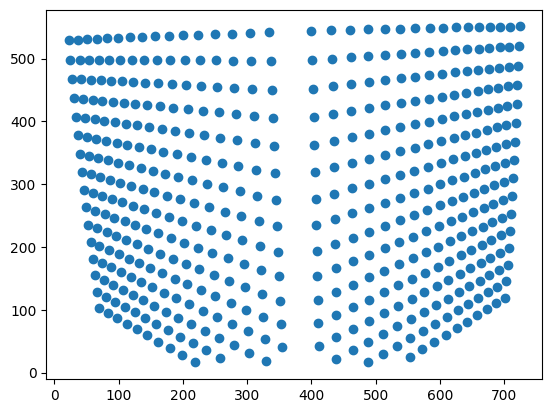

In [4]:
#plot the 2d points

plt.scatter(pts2d[:, 0], pts2d[:, 1])
plt.show()

`pts2d` and `pts3d` are two vector of corresponding points in the image and in 3D. We will use these correspondences to calibrate the camera.

### Linear Method

We first try to perform camera calibration using the linear method. From the lecture, we know that it ideally solves an equation ($\mathbf 0$ being a vector, and $\mathbf p$ a vector representation of the camera matrix)

$$A \mathbf p = \mathbf 0$$

**1.** Build the matrix `A` that defines this calibration equation. What are its dimensions?

In [5]:
"""
A represents the calibration equation. It is a 2n x 12 matrix, where n is the number of points and 12 is the number of unknowns in the camera matrix.
p is a 12 x 1 vector, of the camera calibration parameters.

We build A by stacking the equations for each point.
For each point, we have the following equations (one for each coordinate):

0 = (X, Y, Z, 1, 0, 0, 0, 0, -xX, -xY, -xZ, -x) * p
0 = (0, 0, 0, 0, X, Y, Z, 1, -yX, -yY, -yZ, -y) * p

where x and y are the 2d coordinates of the point, and X, Y, Z are the 3d coordinates of the point.
"""

pts2d = np.concatenate((pts2d, np.ones((nb_points, 1))), axis=1)
pts3d = np.concatenate((pts3d, np.ones((nb_points, 1))), axis=1)


def find_A(pts2d, pts3d):
    nb_points = pts2d.shape[0]
    A = np.zeros((2 * nb_points, 12))

    for i in range(nb_points):
        p2 = pts2d[i]
        p3 = pts3d[i]

        A[2 * i, :4] = p3
        A[2 * i, 8:] = -p2[0] * p3
        A[2 * i + 1, 4:8] = p3
        A[2 * i + 1, 8:] = -p2[1] * p3
    
    return A

A = find_A(pts2d, pts3d)

**2.a)** Perform SVD (using `np.linalg.svd`) on `A` .<br/>
**b)** Check that the SVD is coherent and that one of the singular value is close to $0$ .<br/>
**c)** Use this SVD to compute the camera matrix `P`.

In [6]:
# 2.a SVD : Singular Value Decomposition. It is a method to decompose a matrix into three matrices, U, S and V, such that A = U S V^T.
# Numpy already returns V^T, so we don't need to transpose it.

def get_SVD(A):
    SVD = np.linalg.svd(A)

    U = SVD[0]
    S = SVD[1]
    V = SVD[2]

    sdiag = np.diag(S)
    s_values = S
    S = np.zeros((U.shape[1], V.shape[0]))
    S[:sdiag.shape[0], :sdiag.shape[1]] = sdiag

    return U, S, V

U, S, V = get_SVD(A)

print("U shape : ", U.shape)
print("S shape : ", S.shape)
print("V shape : ", V.shape)

# S has shape (12,), but it should be (982, 12).
# This is because S represents the diagonal of a 982 x 12 matrix.

U shape :  (982, 982)
S shape :  (982, 12)
V shape :  (12, 12)


In [7]:
# 2.b Check that the SVD is correct

USV = np.dot(U, np.dot(S, V))
Err = A - USV

print("Error : ", np.linalg.norm(Err))

print("Minimum singular value : ", np.min(S[11, 11]))

Error :  1.964175279866196e-08
Minimum singular value :  0.04316114614609244


In [8]:
# 2.c Compute the camera matrix (such that A * p = 0)

# The solution is the last column of V, corresponding to the smallest singular value.

p = V[-1]

print("p : ", p)

print("A * p : ", np.linalg.norm(np.dot(A, p)))

p = np.reshape(p, (3, 4))

p :  [-4.53359881e-03 -5.65451256e-04  2.02849590e-03 -5.23179344e-01
 -1.84278426e-03  4.15975903e-03 -1.68779276e-03 -8.52192928e-01
 -3.25683227e-06 -1.13804182e-06 -3.35237791e-06 -1.43209220e-03]
A * p :  0.043161146146149146


**3.** Write a function `projection_error(P, pts3d, pts2d)` that computes the measurement error (Mean Squared Error) between the 3D points projected with a matrix `P`, and the 2D points.

In [9]:
# 3. Compute the error of the projection

def projection(P, pts3d):
    """
    Project the 3D points pts3d using the camera matrix P.
    """
    pts3d_proj = np.dot(P, pts3d.T).T
    pts3d_proj /= pts3d_proj[:, -1:]

    return pts3d_proj

def projection_error(P, pts3d, pts2d):
    """
    Compute the projection error of the 3D points on the 2D points, using the camera matrix P.
    """    
    pts3d_proj = np.dot(P, pts3d.T).T
    pts3d_proj /= pts3d_proj[:, -1:]

    error = np.linalg.norm(pts2d - pts3d_proj, axis=1) ** 2

    return error

errors = projection_error(p, pts3d, pts2d)
print("Mean error : ", np.mean(errors))

Mean error :  0.9165269934974409


**4.** Visualize the projected 3D points and the 2D points on the same figure (use `plt.scatter` with different `marker` options).

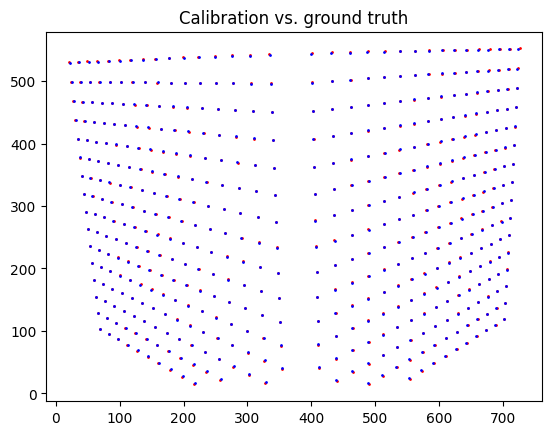

In [10]:
def visualize(P, pts3d, pts2d, title="Calibration vs. ground truth"):
    pts3d_proj = projection(P, pts3d)
    pts3d_proj = pts3d_proj[:, :2]

    plt.scatter(pts3d_proj[:, 0], pts3d_proj[:, 1], c='r', s=1)
    plt.scatter(pts2d[:, 0], pts2d[:, 1], c='b', s=1)
    plt.title(title)
    plt.show()

visualize(p, pts3d, pts2d)

### Camera parameters

We want to extract the parameters of the camera from the matrix `P`, *i.e.*, the internal $(3\times 3)$ calibration matrix $\mathcal K$, the external $(3\times 3)$ rotation matrix $R$ and the $(3\times 1)$ translation vector $\mathbf t$ so that:

$$P=\mathcal K [R | \mathbf t]$$

To do so, we are going to use the formulas from the lectures, and the numpy functions (`np.linalg.norm`, `np.linalg.inv`, `np.dot`, `np.cross`...).

**5.a)** Write a function `camera_parameters(P, eps=1)` that takes as input the camera matrix `P` and a sign `eps` ($\varepsilon$, the sign of $\rho$ in the equations from the lecture), and outputs three values `K`, `R` and `t` that correspond to the intrinsic and extrinsic parameters of the camera. <br/>
**b)** Display the results for `eps=1` and check that your values `(K, R, t)` can correctly reconstruct `P`.

In [11]:
# 5.a Compute the camera parameters :

def camera_parameters(P, eps=1):
    """
    Compute the intrinsic (K) and extrinsic (R, t) parameters of the camera matrix P.
    eps is the sign of rho
    """

    # Extract the last column of P as b, and the rows of the rest of P as a_i
    b = P[:, 3:]
    A = P[:, :3]
    a_1 = A[0]
    a_2 = A[1]
    a_3 = A[2]

    rho = eps / np.linalg.norm(a_3)

    u_0 = rho**2 * np.dot(a_1, a_3)
    v_0 = rho**2 * np.dot(a_2, a_3)

    a_1_3 = np.cross(a_1, a_3)
    a_2_3 = np.cross(a_2, a_3)

    costheta = np.dot(a_1_3, a_2_3) / (np.linalg.norm(a_1_3) * np.linalg.norm(a_2_3))
    theta = np.arccos(costheta)

    alpha = rho**2 * np.linalg.norm(a_1_3) * np.sin(theta)
    beta  = rho**2 * np.linalg.norm(a_2_3) * np.sin(theta)

    r1 = a_2_3 / np.linalg.norm(a_2_3)
    r3 = a_3 * rho
    r2 = np.cross(r3, r1)

    K = np.array([[alpha, -alpha * np.cos(theta)/np.sin(theta), u_0], [0, beta / np.sin(theta), v_0], [0, 0, 1]])
    R = np.vstack((r1, r2, r3))
    t = rho * np.dot(np.linalg.inv(K), b)

    return K, R, t.reshape((3, 1))

def reconstruct_P(K, R, t, eps=1):
    """
    Reconstruct the camera matrix P from its parameters (K, R, t).

    We have for eps = -1 that t = -t and r2, r3 = -r2, -r3. But r1 is unchanged since r2 is the cross product of r3 and r1
    """

    if eps == -1:
        t = -t
        R[1:, :] = -R[1:, :]
    
    P = np.dot(K, np.hstack((R, t)))
    # We sucessfully reconstruct P up to a constant factor.

    return P

**6.** The sign of $\rho$ is not easy to decide a priori: test your function with both choices of `eps`, and comment on which option makes more sense (is the object in front of the camera?)

In [12]:
# 6. Compute the camera parameters for eps = 1 and eps = -1

K, R, t = camera_parameters(p, 1)
K2, R2, t2 = camera_parameters(p, -1)

P =  reconstruct_P(K, R, t, 1)
P2 = reconstruct_P(K2, R2, t2, -1)

error = np.mean(projection_error(P, pts3d, pts2d))
error2 = np.mean(projection_error(P2, pts3d, pts2d))

print("t_z for eps = +1 : ", t[2].item())
print("error for eps = +1 : ", error)

print("t_z for eps = -1 : ", t2[2].item())
print("error for eps = -1 : ", error2)

t_z for eps = +1 :  -297.70374575226566
error for eps = +1 :  0.9196079524462998
t_z for eps = -1 :  297.70374575226566
error for eps = -1 :  0.9196079524462998


In [13]:
"""
Since it is more natural that the camera is looking towards the positive z axis, we choose eps = 1.
"""

'\nSince it is more natural that the camera is looking towards the positive z axis, we choose eps = 1.\n'

### Non linear method

**7.a)** Improve the estimate of the camera matrix using non linear least squares: use `projection_error` from **3.** and `optimize.leastsq` which implements a variant of Levenberg-Marquardt (read the documentation to use it appropriately). <br/>
**b)** Compare the reprojection error before and after the optimization.

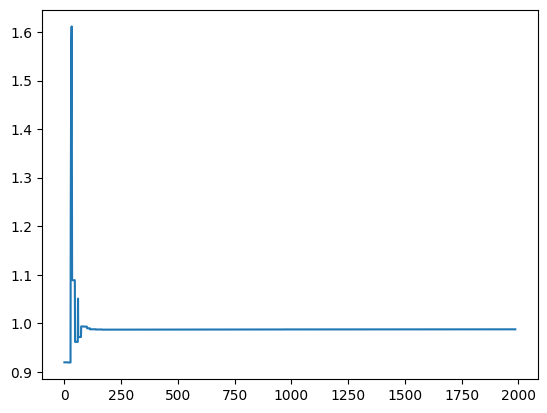

c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 2600.
  warnings.warn(errors[info][0], RuntimeWarning)


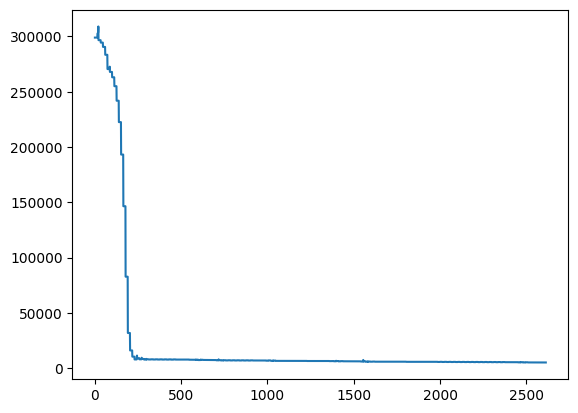

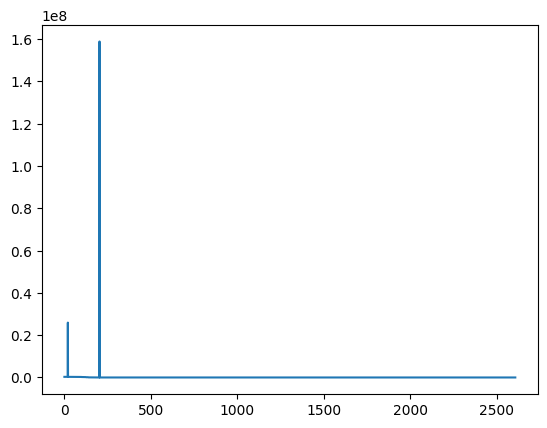

Initial error :  0.9196079524462998
Optimized error :  0.9875945337484694
Optimized error (all ones starting point) :  5209.096783304045
Optimized error (random starting point) :  2099.1029728188028


In [14]:
def func1(P, pts3d, pts2d, list_errors):
    """
    Compute the error between the projection of the 3D points and the 2D points.
    """
    P = P.reshape((3, 4))
    errors = projection_error(P, pts3d, pts2d)
    list_errors.append(np.mean(errors))

    return errors

def optimize_camera_parameters(pts3d, pts2d, P, func=func1, plot_error=False):
    """
    Optimize the camera parameters using the Levenberg-Marquardt algorithm.
    Use optimize.leastsq to solve the problem.
    """
    errors = []
    
    params = P.flatten()
    opt = optimize.leastsq(func, params, (pts3d, pts2d, errors))[0]

    if plot_error:
        plt.plot(errors)
        plt.show()

    return opt.reshape((3, 4))

P_opt = optimize_camera_parameters(pts3d, pts2d, P, plot_error=True)
P_opt_null = optimize_camera_parameters(pts3d, pts2d, np.ones((3, 4)), plot_error=True)
P_opt_random = optimize_camera_parameters(pts3d, pts2d, np.random.rand(3, 4), plot_error=True)

err = projection_error(P, pts3d, pts2d)
err = np.mean(err)
err_opt = projection_error(P_opt, pts3d, pts2d)
err_opt = np.mean(err_opt)
err_opt_null = projection_error(P_opt_null, pts3d, pts2d)
err_opt_null = np.mean(err_opt_null)
err_opt_random = projection_error(P_opt_random, pts3d, pts2d)
err_opt_random = np.mean(err_opt_random)

print("Initial error : ", err)
print("Optimized error : ", err_opt)
print("Optimized error (all ones starting point) : ", err_opt_null)
print("Optimized error (random starting point) : ", err_opt_random)

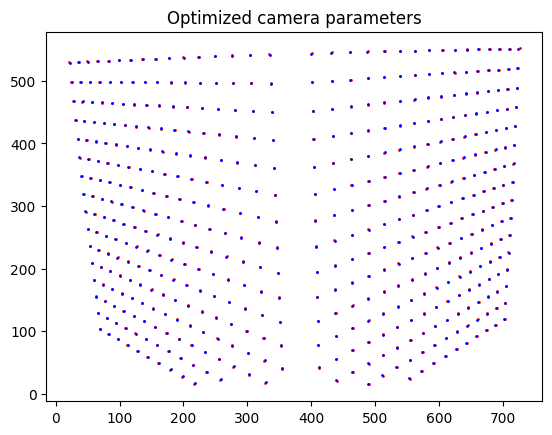

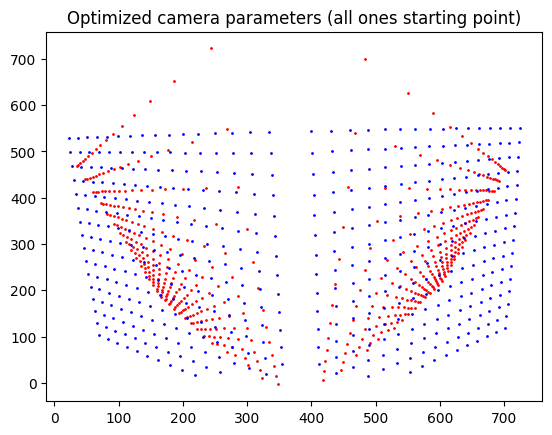

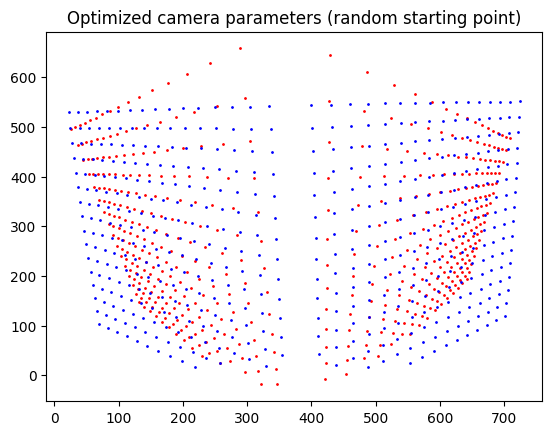

In [15]:
visualize(P_opt, pts3d, pts2d, title="Optimized camera parameters")
visualize(P_opt_null, pts3d, pts2d, title="Optimized camera parameters (all ones starting point)")
visualize(P_opt_random, pts3d, pts2d, title="Optimized camera parameters (random starting point)")

We already had the best possible solution given the singular value decomposition. For the first few iterations, the algorithm succesfully improves our solution, but by a negligible amount that can be seen as the approximation errors during our computations. After that it seems to explode for an unknown reason, and then get better, but never as good as the original calibration.

When starting from ones, we have a bad convergence.
When starting from a random point we sometimes converge to a good solution, sometimes the algorithm explodes.

Now try with normalised data points

In [16]:
norma_pts2d = np.concatenate((norma_pts2d, np.ones((nb_points, 1))), axis=1)
norma_pts3d = np.concatenate((norma_pts3d, np.ones((nb_points, 1))), axis=1)

A_norma = find_A(norma_pts2d, norma_pts3d)
U_norma, S_norma, V_norma = get_SVD(A_norma)
p_norma = V_norma[-1]

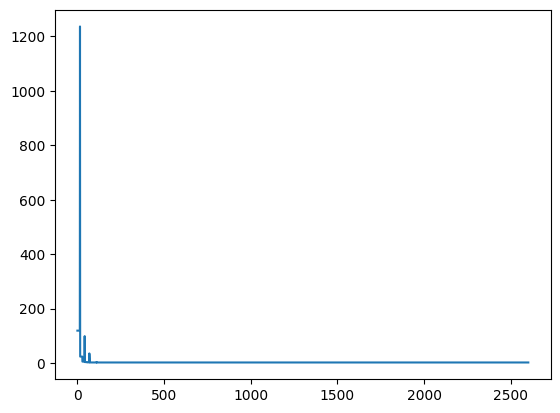

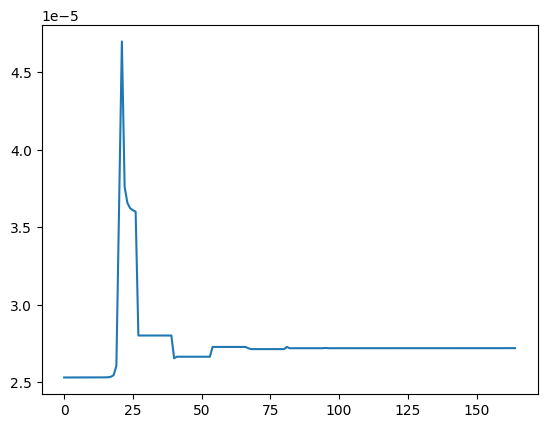

Optimized error (normalized points) :  1.9663762782624987
Optimized error (normalized points, random init) :  2.71880355316362e-05


In [17]:
P_opt = optimize_camera_parameters(norma_pts3d, norma_pts2d, np.random.rand(3, 4), plot_error=True)
P_opt_random = optimize_camera_parameters(norma_pts3d, norma_pts2d, p_norma, plot_error=True)

err = projection_error(P_opt, norma_pts3d, norma_pts2d)
err_rd = projection_error(P_opt_random, norma_pts3d, norma_pts2d)
err = np.mean(err)
err_rd = np.mean(err_rd)

print("Optimized error (normalized points) : ", err)
print("Optimized error (normalized points, random init) : ", err_rd)

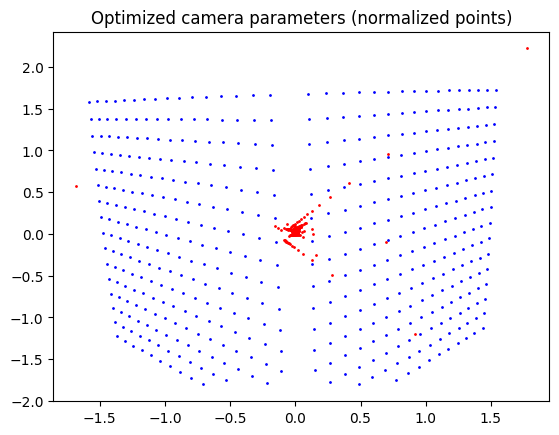

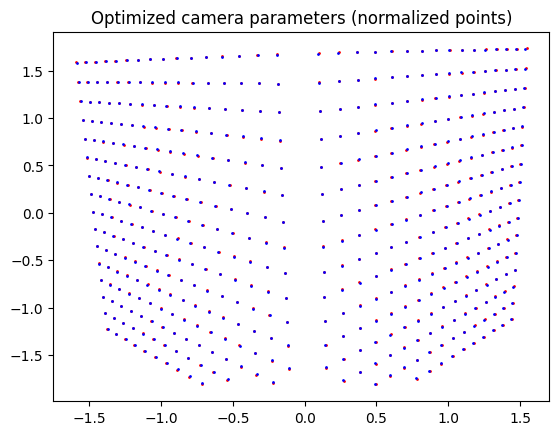

In [18]:
visualize(P_opt, norma_pts3d, norma_pts2d, title="Optimized camera parameters (normalized points)")
visualize(P_opt_random, norma_pts3d, norma_pts2d, title="Optimized camera parameters (normalized points)")

Now it seems that the algorithm just tries to put everything to 0 since everything is close to 0...
When we initialise P as before, we observe the same behavior.